In [2]:
import requests
import base64
import numpy as np
import os
from dotenv import load_dotenv

In [3]:
load_dotenv()
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')

In [77]:
# base64 encode the client_ID and client_Secret
client_credentials = f'{CLIENT_ID}:{CLIENT_SECRET}'
client_credentials_base64 = base64.b64encode(client_credentials.encode())

In [79]:
# Request Access Token
token_url = 'https://accounts.spotify.com/api/token'
headers = {
    'Authorization': f'Basic {client_credentials_base64.decode()}'
}
data = {
    'grant_type': 'client_credentials'
}
response = requests.post(token_url, data=data, headers=headers)

if response.status_code == 200:
    access_token = response.json()['access_token']
    print('Access token finessed')
else:
    print('did not finess access token')
    exit()

Access token finessed


In [80]:
access_token

'BQADgUMY8T-irNKiOlBh-68idPyumvxw9i9-2OHSMdeNPVkuPJmr-mElH9WsDQ4amCIR6TfFnQlNPXoasPViJGqjbeRZAX6LOLiEZHFUEBg2gb7EzLQ'

In [81]:
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [82]:
def generate_playlist_data(playlist_id, access_token):
    sp = spotipy.Spotify(auth=access_token) # Setup spotipy with access token
    
    # Get tracks from playlists
    playlist_tracks = sp.playlist_tracks(playlist_id=playlist_id, fields='items(track(id, name, artists, album(id, name)))')
    
    # Extract relevant info and store in a list of dicts
    music_data = []
    for track_info in playlist_tracks['items']:
        track = track_info['track']
        track_name = track['name']
        artists = ', '.join([artist['name'] for artist in track['artists']])
        album_name = track['album']['name']
        album_id = track['album']['id']
        track_id = track['id']
        
        # Get audio features for the track
        audio_features = sp.audio_features(track_id)[0] if track_id != 'Not avaliable' else None
        
        # Get release date of album
        try:
            album_info = sp.album(album_id=album_id) if album_id != 'Not avaliable' else None
            release_date = album_info['release_date'] if album_info else None
        except:
            release_date = None
        
        # Get popularity of the track
        try:
            track_info = sp.track(track_id=track_id) if track_id != 'Not avaliable' else None
            popularity = track_info['popularity'] if track_info else None
        except:
            popularity = None
            
        # Create dict and add any additional info
        track_data = {
            'Track Name': track_name,
            'Artists': artists,
            'Track ID': track_id,
            'Album Name': album_name,
            'Album ID': album_id,
            'Popularity': popularity,
            'Release Date': release_date,
            'Duration (ms)': audio_features['duration_ms'] if audio_features else None,
            'Explicit': track_info.get('explicit', None),
            'External URLs': track_info.get('external_urls', {}).get('spotify', None),
            'Danceability': audio_features['danceability'] if audio_features else None,
            'Energy': audio_features['energy'] if audio_features else None,
            'Key': audio_features['key'] if audio_features else None,
            'Loudness': audio_features['loudness'] if audio_features else None,
            'Mode': audio_features['mode'] if audio_features else None,
            'Speechiness': audio_features['speechiness'] if audio_features else None,
            'Acousticness': audio_features['acousticness'] if audio_features else None,
            'Instrumentalness': audio_features['instrumentalness'] if audio_features else None,
            'Liveness': audio_features['liveness'] if audio_features else None,
            'Valence': audio_features['valence'] if audio_features else None,
            'Tempo': audio_features['tempo'] if audio_features else None,
        }
        
        music_data.append(track_data)
        
    # Create pandas df from the list of dicts
    df = pd.DataFrame(music_data)
    return df

In [83]:
spotify_playlist_id = '5MgzUBZidpO27woQ33DUS8'
df = generate_playlist_data(playlist_id=spotify_playlist_id, access_token=access_token)

In [84]:
print(df.shape)
df

(100, 21)


,Track Name,Artists,Track ID,Album Name,Album ID,Popularity,Release Date,Duration (ms),Explicit,External URLs,...,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,Kevin’s Heart,J. Cole,6tZ3b7ik1QDXFAZlXib0YZ,KOD,4Wv5UAieM1LDEYVq5WmqDd,70,2018-04-20,200310,True,https://open.spotify.com/track/6tZ3b7ik1QDXFAZ...,...,0.527,6,-6.644,0,0.367,0.4820,0.000000,0.631,0.475,116.079
1,Photosynthesis,"Saba, Jean Deaux",3DlgDXIYtnWtJKiB8bZQMv,Bucket List Project,10UscF31tC7Sz8S2a1mGbM,25,2016-10-27,201733,True,https://open.spotify.com/track/3DlgDXIYtnWtJKi...,...,0.662,7,-8.393,1,0.270,0.5360,0.000005,0.593,0.634,111.130
2,Tide Pen (feat. Jack Harlow),"Smokepurpp, Jack Harlow",4Wh3znTCMTIKAZ2stlikRX,Florida Jit,5z3ZfPgoJDN2y1QXbYg4zY,44,2020-06-19,144874,True,https://open.spotify.com/track/4Wh3znTCMTIKAZ2...,...,0.661,4,-2.968,0,0.135,0.1000,0.000004,0.279,0.498,173.223
3,Run It Up (feat. Offset & Moneybagg Yo),"Lil Tjay, Offset, Moneybagg Yo",1dg3qy5DjoJodawfOCgrTP,Destined 2 Win,3MEKpJ7wSSp6Z661ThjrUJ,71,2021-04-02,232048,True,https://open.spotify.com/track/1dg3qy5DjoJodaw...,...,0.575,6,-6.091,1,0.163,0.4150,0.000000,0.109,0.671,120.031
4,Free Youngboy,NLE Choppa,3cuykPS9TJOWufYPvTUOTN,Free Youngboy,0PxR6TfDziT6v7bU4xOnFA,43,2019-06-14,164833,True,https://open.spotify.com/track/3cuykPS9TJOWufY...,...,0.791,10,-6.581,0,0.255,0.0133,0.000000,0.361,0.838,87.497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Plain Jane,A$AP Ferg,4dVpf9jZjcORqGTLUaeYj9,Still Striving,0tQ7Iu6EicQTPyhYRNWjaT,69,2017-08-18,173600,True,https://open.spotify.com/track/4dVpf9jZjcORqGT...,...,0.844,11,-5.482,1,0.275,0.0651,0.000000,0.087,0.520,170.142
96,Beethoven,Kenndog,7rYCenkV4OXJgiUuKrhDCb,Beethoven,4Kwr6fNGEb6lYZRJQ0kSU2,56,2021-08-29,144588,True,https://open.spotify.com/track/7rYCenkV4OXJgiU...,...,0.652,9,-8.915,0,0.114,0.1500,0.000006,0.106,0.503,102.963
97,Ni**as In Paris,"JAY-Z, Kanye West",4Li2WHPkuyCdtmokzW2007,Watch The Throne (Deluxe),2P2Xwvh2xWXIZ1OWY9S9o5,13,2011-08-08,219333,True,https://open.spotify.com/track/4Li2WHPkuyCdtmo...,...,0.858,1,-5.542,1,0.311,0.1290,0.000000,0.349,0.776,140.022
98,Unapologetic (with NLE Choppa),"Polo G, NLE Choppa",45vDAZmpEf8BGVd1EA9yLA,Hall of Fame 2.0,2rLqUcipEjIKK9rma5OTN8,57,2021-12-03,168000,True,https://open.spotify.com/track/45vDAZmpEf8BGVd...,...,0.707,5,-5.444,0,0.255,0.0862,0.000000,0.334,0.627,160.000


# Perform some EDA on the Data

In [85]:
# Check for null values
print(df.isnull().sum())

Track Name          0
Artists             0
Track ID            0
Album Name          0
Album ID            0
Popularity          0
Release Date        0
Duration (ms)       0
Explicit            0
External URLs       0
Danceability        0
Energy              0
Key                 0
Loudness            0
Mode                0
Speechiness         0
Acousticness        0
Instrumentalness    0
Liveness            0
Valence             0
Tempo               0
dtype: int64


In [86]:
df.describe()

,Popularity,Duration (ms),Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000
mean,47.160000,188291.930000,0.770900,0.579810,5.200000,-7.154690,0.55,0.220349,0.162151,0.001335,0.194229,0.433471,126.69165
std,27.361301,48851.127336,0.101568,0.143215,3.776589,2.136591,0.50,0.147746,0.176751,0.010179,0.143316,0.211015,30.84241
min,0.000000,98449.000000,0.516000,0.314000,0.000000,-12.142000,0.00,0.038200,0.002020,0.000000,0.055600,0.062000,65.98800
25%,26.750000,149312.750000,0.693250,0.464750,1.000000,-8.581750,0.00,0.087675,0.029050,0.000000,0.104750,0.275250,107.25250
50%,57.000000,186260.500000,0.795500,0.583500,5.500000,-6.938000,1.00,0.212500,0.094500,0.000000,0.129000,0.421000,129.93350
75%,69.000000,214948.750000,0.841000,0.662250,8.000000,-5.472500,1.00,0.311500,0.227000,0.000005,0.244750,0.597500,146.55525
max,81.000000,309323.000000,0.970000,0.936000,11.000000,-2.968000,1.00,0.856000,0.810000,0.101000,0.668000,0.871000,202.01800


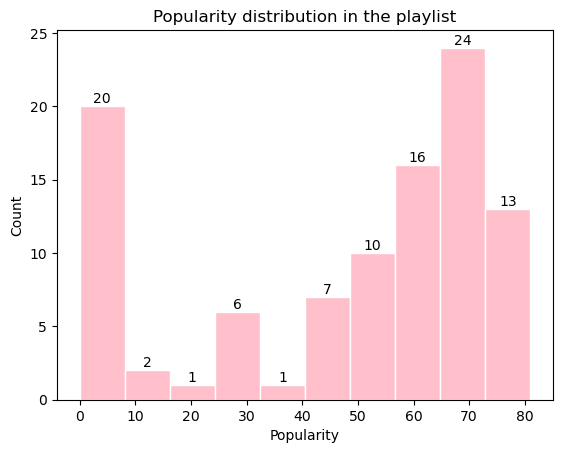

In [87]:
# Plot some playlist stats
import matplotlib.pyplot as plt

# Histogram: Distribution of track popularity
hist_values, bin_edges, _ = plt.hist(df['Popularity'], bins=10, edgecolor='white', color='pink')
plt.title("Popularity distribution in the playlist")
plt.xlabel("Popularity")
plt.ylabel("Count")

for i in range(len(hist_values)):
    plt.text(bin_edges[i] + (bin_edges[i+1] - bin_edges[i]) / 2, # X Position: Calculate the center of bin to place text
             hist_values[i]+0.5,    # Y Position: bin height + 0.5 to place text above bin
             int(hist_values[i]), # Text to display (count of songs for that bin)
             ha = 'center', va = 'center' # Horizontal and Vertical alignment
             )

plt.show()

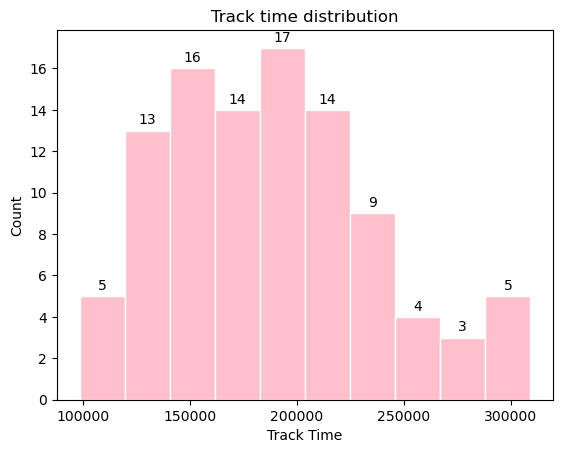

In [88]:
# Histogram: Distribution of duration of track
hist_values, bin_edges, _ = plt.hist(df['Duration (ms)'], bins=10, edgecolor='white', color='pink')
plt.title('Track time distribution')
plt.xlabel('Track Time')
plt.ylabel('Count')
for i in range(len(hist_values)):
    plt.text(bin_edges[i] + (bin_edges[i+1] - bin_edges[i]) / 2,
             hist_values[i] + 0.5,
             int(hist_values[i]),
             ha = 'center', va = 'center'
             )
plt.show()

In [105]:
# Correlation Matrix: audio features correlation
correlation_features = df.iloc[:, np.r_[5, 10: df.shape[1]]] #Use just pupularity and every column from 10 to end
correlation_matrix = correlation_features.corr()
correlation_matrix

,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
Popularity,1.000000,0.125455,-0.033273,-0.003636,0.101911,-0.055966,0.069164,0.154665,0.097521,0.037535,-0.060183,-0.008293
Danceability,0.125455,1.000000,-0.238220,-0.185151,-0.078397,0.073892,-0.016462,-0.044993,0.048848,-0.350789,0.092114,-0.291716
Energy,-0.033273,-0.238220,1.000000,0.141744,0.663668,-0.100795,0.033764,-0.096968,0.058467,0.270328,0.325136,0.164976
Key,-0.003636,-0.185151,0.141744,1.000000,0.022427,-0.353052,-0.040395,0.018068,0.128672,0.070549,0.236124,0.005611
Loudness,0.101911,-0.078397,0.663668,0.022427,1.000000,-0.058566,-0.032090,-0.227741,0.120406,0.069536,0.042506,0.115577
Mode,-0.055966,0.073892,-0.100795,-0.353052,-0.058566,1.000000,0.000999,0.139461,-0.097362,-0.048462,-0.154626,0.089381
Speechiness,0.069164,-0.016462,0.033764,-0.040395,-0.032090,0.000999,1.000000,0.129194,-0.005285,0.052763,0.151075,0.063569
Acousticness,0.154665,-0.044993,-0.096968,0.018068,-0.227741,0.139461,0.129194,1.000000,-0.093930,0.179048,0.169584,-0.086805
Instrumentalness,0.097521,0.048848,0.058467,0.128672,0.120406,-0.097362,-0.005285,-0.093930,1.000000,-0.031990,-0.017698,0.062405
Liveness,0.037535,-0.350789,0.270328,0.070549,0.069536,-0.048462,0.052763,0.179048,-0.031990,1.000000,0.165257,0.020560


In [106]:
correlation_features.head()

,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
0,70,0.829,0.527,6,-6.644,0,0.367,0.4820,0.000000,0.631,0.475,116.079
1,25,0.777,0.662,7,-8.393,1,0.270,0.5360,0.000005,0.593,0.634,111.130
2,44,0.575,0.661,4,-2.968,0,0.135,0.1000,0.000004,0.279,0.498,173.223
3,71,0.880,0.575,6,-6.091,1,0.163,0.4150,0.000000,0.109,0.671,120.031
4,43,0.698,0.791,10,-6.581,0,0.255,0.0133,0.000000,0.361,0.838,87.497


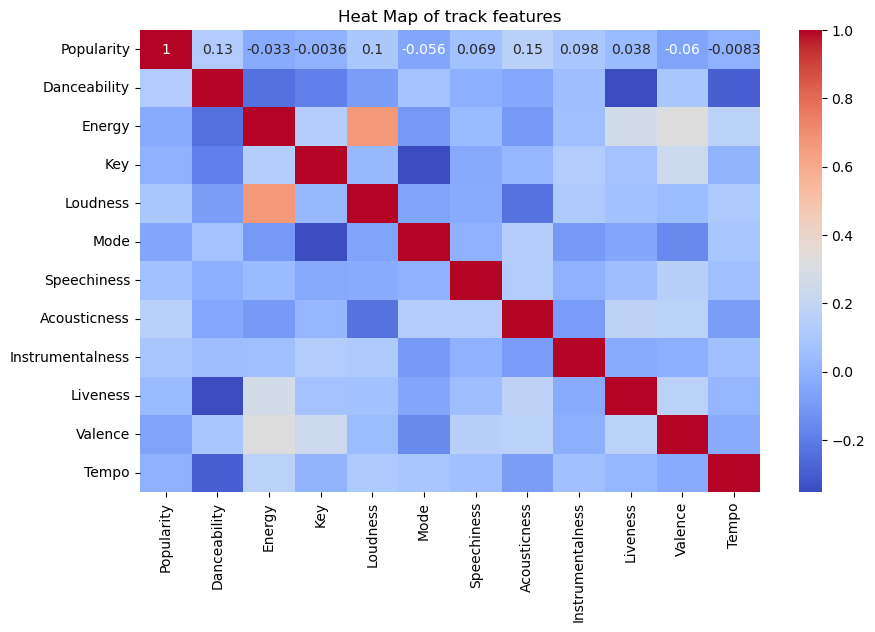

In [107]:
# Heat map representation of corr matrix
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Heat Map of track features')
plt.show()

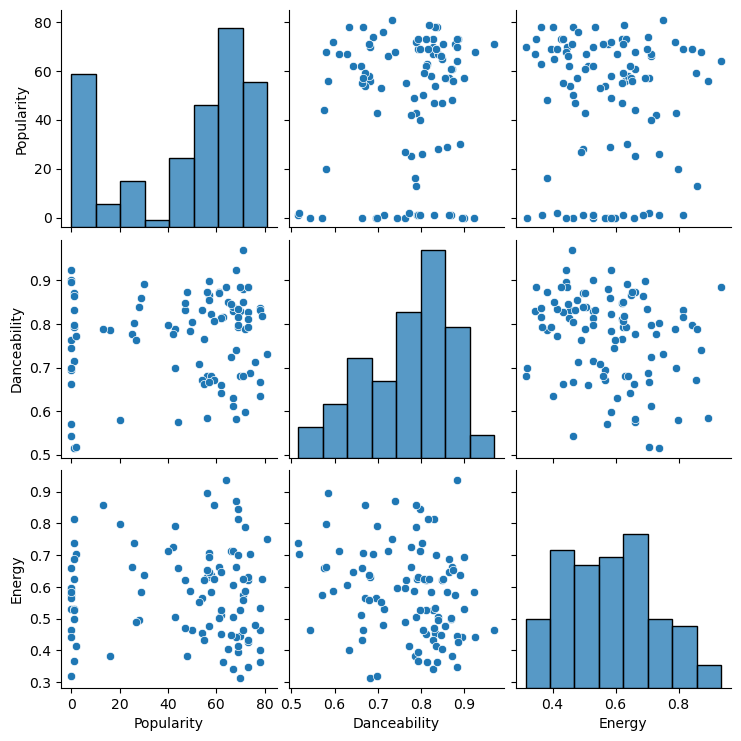

In [108]:
# Pair Plot: pairwise relationships between features
sns.pairplot(correlation_features[['Popularity', 'Danceability', 'Energy']])

# Building the actual recommendation system

In [109]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics.pairwise import cosine_similarity

In [123]:
# Normalize the song featues
scaler = MinMaxScaler()
song_features = correlation_features.iloc[:, 2:]
song_features_normalized = scaler.fit_transform(song_features)
song_features_normalized

array([[3.42443730e-01, 5.45454545e-01, 5.99302376e-01, 0.00000000e+00,
        4.02054292e-01, 5.94049358e-01, 0.00000000e+00, 9.39581973e-01,
        5.10506799e-01, 3.68234948e-01],
       [5.59485531e-01, 6.36363636e-01, 4.08654894e-01, 1.00000000e+00,
        2.83443385e-01, 6.60882695e-01, 4.56435644e-05, 8.77531025e-01,
        7.07045735e-01, 3.31853268e-01],
       [5.57877814e-01, 3.63636364e-01, 1.00000000e+00, 0.00000000e+00,
        1.18366349e-01, 1.21265378e-01, 3.48514851e-05, 3.64794252e-01,
        5.38936959e-01, 7.88318753e-01],
       [4.19614148e-01, 5.45454545e-01, 6.59581426e-01, 1.00000000e+00,
        1.52604549e-01, 5.11126513e-01, 0.00000000e+00, 8.71979099e-02,
        7.52781211e-01, 3.97287363e-01],
       [7.66881029e-01, 9.09090909e-01, 6.06169610e-01, 0.00000000e+00,
        2.65101492e-01, 1.39607416e-02, 0.00000000e+00, 4.98693664e-01,
        9.59208900e-01, 1.58119532e-01],
       [2.44372990e-01, 0.00000000e+00, 3.78678875e-01, 1.00000000e+00,
   

In [183]:
# Generate music based on the audio features of songs (content-based filtering)
def content_based_filtering(input_song, num_recommendations):
    if input_song not in df['Track Name'].values:
        print(f'{input_song} not in dataset')
        return

    # retrieve the index of the input song in dataset
    input_song_index = df[df['Track Name'].str.lower() == input_song.lower()].index[0]
    
    # calculate similarity score based on music features using Cosine Similarity
    similarity_scores = cosine_similarity([song_features_normalized[input_song_index]], song_features_normalized)
    
    # retrieve indices of most similar songs
    similar_song_indices = similarity_scores.argsort()[0][::-1][1:num_recommendations+1] # sort the array, slice the array
    
    # retrieve names of the most similar songs based on content-based filtering
    content_based_recommendations = df.iloc[similar_song_indices][['Track Name', 'Artists', 'Album Name', 'Release Date', 'Popularity']]
    
    return content_based_recommendations
    

In [184]:
input_song = "XO Tour Llif3"
num_recommendations = 5
recommendations = content_based_filtering(input_song=input_song, num_recommendations=num_recommendations)
recommendations

,Track Name,Artists,Album Name,Release Date,Popularity
39,44 More,Logic,Bobby Tarantino II,2018-03-09,58
54,FRANCHISE (feat. Young Thug & M.I.A.),"Travis Scott, Young Thug, M.I.A.",FRANCHISE (feat. Young Thug & M.I.A.),2020-09-25,69
64,T-Shirt,Migos,Culture,2017-04-07,1
96,Beethoven,Kenndog,Beethoven,2021-08-29,56
87,Ashes,BONES,FromBeyondTheGrave,2020-11-07,61


In [185]:
# Generate music based on weighted popularity and combine with content based filtering

# To provide recommendations we have to recommend latest songs, so add weights to latest releases
def calculate_weighted_popularity(release_date): # calculate the weighted popularity based on release date
    release_date = datetime.strptime(release_date, '%Y-%m-%d') # Convert release date to datetime object
    time_span = datetime.now() - release_date # Calculate how long its been since the song released
    weight = 1 / (time_span.days + 1)   # Weighted pupularity score based on time span
    return weight    

In [186]:
def hybrid_recommendation(input_song, num_recommendations, alpha = 0.5):
    if input_song not in df['Track Name'].values:
        print(f'{input_song} not in dataset')
        return

    content_based_recommendations = content_based_filtering(input_song=input_song, num_recommendations=num_recommendations)
    
    popularity_score = df.loc[df['Track Name'] == input_song, 'Popularity'].values[0]
    
    weighted_popularity = popularity_score * calculate_weighted_popularity(df.loc[df['Track Name'] == input_song, 'Release Date'].values[0])
    
    new_entry = pd.DataFrame({
        'Track Name': [input_song],
        'Artists': [df.loc[df['Track Name'] == input_song, 'Artists'].values[0]],
        'Album Name': [df.loc[df['Track Name'] == input_song, 'Album Name'].values[0]],
        'Release Date': [df.loc[df['Track Name'] == input_song, 'Release Date'].values[0]],
        'Popularity': [weighted_popularity]
    })
    
    hybrid_recommendations = pd.concat([content_based_recommendations, new_entry], ignore_index=True)
    hybrid_recommendations = hybrid_recommendations.sort_values(by='Popularity', ascending=False)
    hybrid_recommendations = hybrid_recommendations[hybrid_recommendations['Track Name'] != input_song]
    
    return hybrid_recommendations


In [187]:
hybrid_recommendations = hybrid_recommendation(input_song=input_song, num_recommendations=num_recommendations)
hybrid_recommendations

,Track Name,Artists,Album Name,Release Date,Popularity
1,FRANCHISE (feat. Young Thug & M.I.A.),"Travis Scott, Young Thug, M.I.A.",FRANCHISE (feat. Young Thug & M.I.A.),2020-09-25,69.0
4,Ashes,BONES,FromBeyondTheGrave,2020-11-07,61.0
0,44 More,Logic,Bobby Tarantino II,2018-03-09,58.0
3,Beethoven,Kenndog,Beethoven,2021-08-29,56.0
2,T-Shirt,Migos,Culture,2017-04-07,1.0
